In [20]:
import pandas as pd
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords

df = pd.read_csv('piere_justin_video_details.csv')

In [21]:
missing_values = df.isnull().sum()
print(missing_values)

# Fill missing numerical values with median
numerical_columns = ['views', 'likes', 'comments']
df[numerical_columns] = df[numerical_columns].fillna(df[numerical_columns].median())

# For categorical data fill with 'Unknown' value
categorical_columns = ['tags', 'category', 'defaultAudioLanguage']
df[categorical_columns] = df[categorical_columns].fillna('Unknown')

# Convert 'publish_time' to datetime
df['publish_time'] = pd.to_datetime(df['publish_time'])

# Function to convert ISO duration format into secs
def parse_duration(duration_str):
    try:
        match = re.match('P(?:(\d+)D)?T(?:(\d+)H)?(?:(\d+)M)?(?:(\d+)S)?', duration_str).groups()
        days, hours, minutes, seconds = [int(group) if group else 0 for group in match]
        total_seconds = days * 24 * 3600 + hours * 3600 + minutes * 60 + seconds
        return total_seconds
    except AttributeError:
        return 0
    
df['duration_seconds'] = df['duration'].apply(parse_duration)

df['tags'] = df['tags'].str.strip("[]").str.replace("'", "").str.split(', ')

df['title_clean'] = df['title'].str.replace(r"[^a-zA-Z0-9\s]", "", regex=True).str.lower()
df['description_clean'] = df['description'].str.replace(r"[^a-zA-Z0-9\s]", "", regex=True).str.lower()

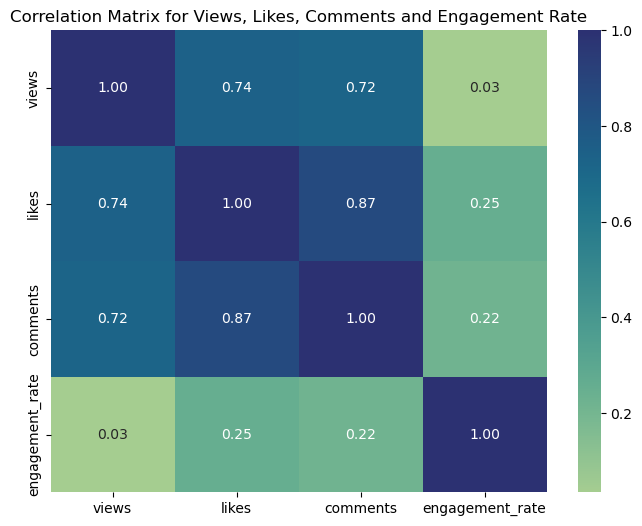

In [22]:
# Calculate engagement rate
df['engagement_rate'] = (df['likes'] + df['comments']) / df['views']

df['engagement_rate'] = df['engagement_rate'].fillna(0)

# Correlation matrix for views, likes, and comments
correlation_matrix = df[['views', 'likes', 'comments', 'engagement_rate']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='crest', fmt=".2f")
plt.title('Correlation Matrix for Views, Likes, Comments and Engagement Rate')
plt.show()


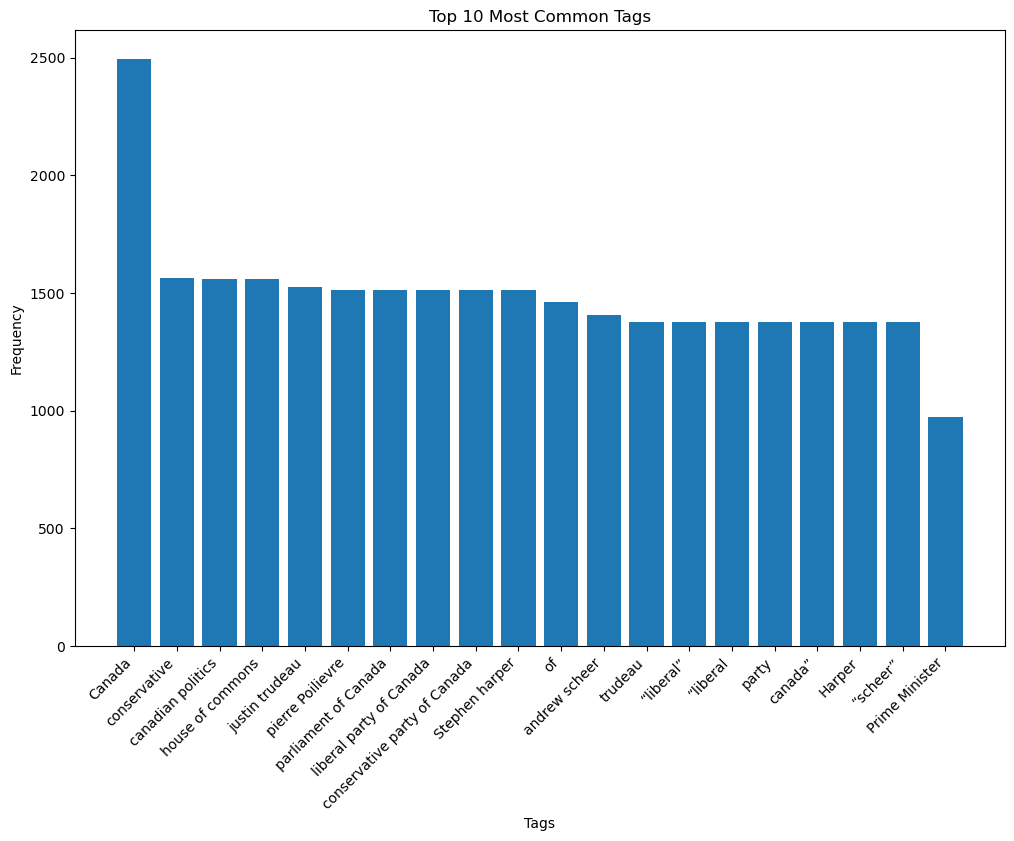

In [23]:
# Most Common Tags

all_tags = [tag for sublist in df['tags'] for tag in sublist]

# Count the frequency of each tag
tag_counts = Counter(all_tags)
most_common_tags = tag_counts.most_common(20)  
tags, counts = zip(*most_common_tags)  

plt.figure(figsize=(12, 8))
plt.bar(tags, counts)
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right') 
plt.title('Top 10 Most Common Tags')
plt.show()

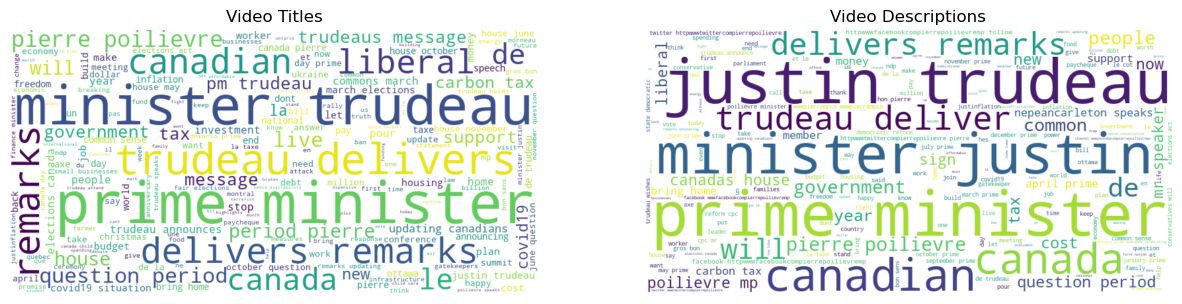

In [24]:
# Convert all non-string entries to strings in 'title_clean' and 'description_clean'
df['title_clean'] = df['title_clean'].astype(str)
df['description_clean'] = df['description_clean'].astype(str)

# titles
title_text = ' '.join(df['title_clean']) 
wordcloud_title = WordCloud(width=800, height=400, background_color='white').generate(title_text)

# descriptions
description_text = ' '.join(df['description_clean'])
wordcloud_description = WordCloud(width=800, height=400, background_color='white').generate(description_text)

plt.figure(figsize=(15, 7.5))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_title, interpolation='bilinear')
plt.title('Video Titles')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_description, interpolation='bilinear')
plt.title('Video Descriptions')
plt.axis('off')

plt.show()


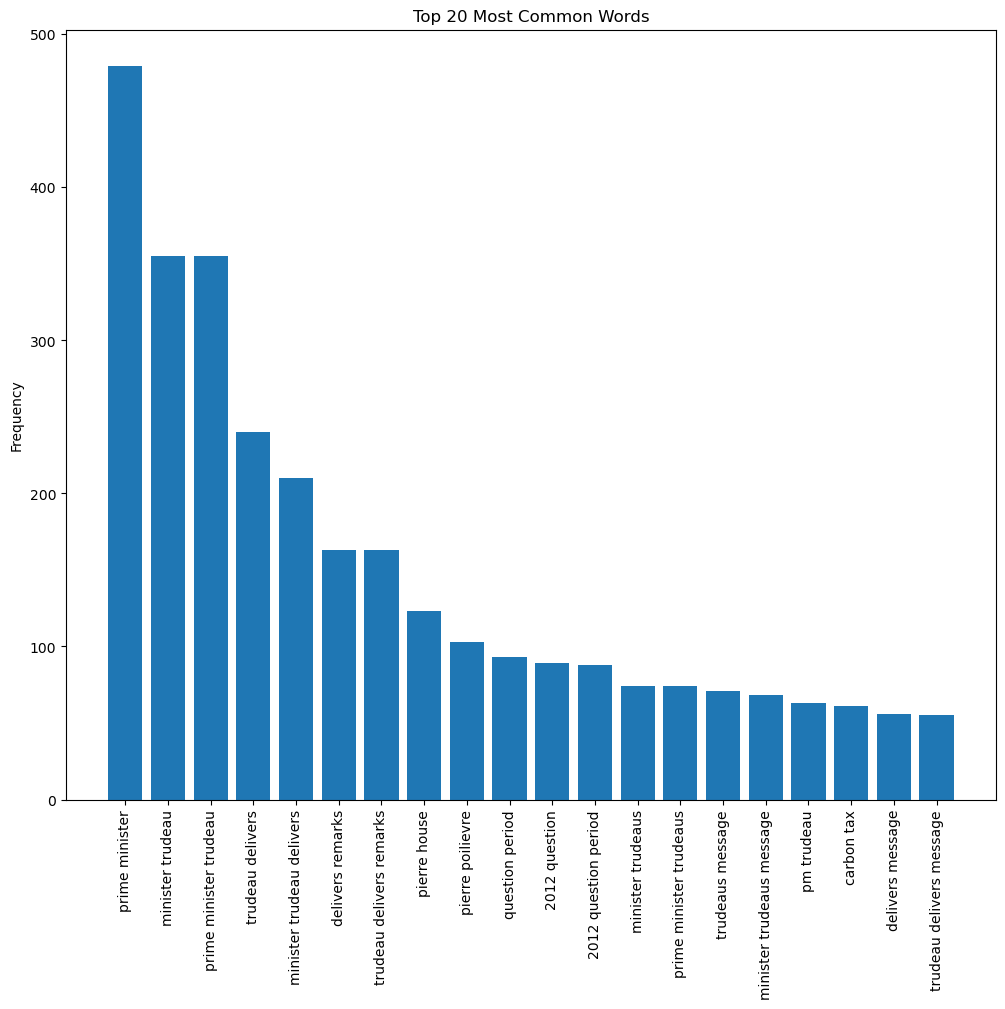

In [27]:
# Most common words
def plot_most_common_ngrams(count_data, count_vectorizer, num_ngrams=20):
    words = count_vectorizer.get_feature_names_out()
    total_counts = count_data.sum(axis=0).A1
    count_dict = zip(words, total_counts)
    count_dict = sorted(count_dict, key=lambda x: x[1], reverse=True)[:num_ngrams]
    words, counts = zip(*count_dict)
    x_pos = range(len(words))

    plt.figure(figsize=(12, 10))
    plt.bar(x_pos, counts, align='center')
    plt.xticks(x_pos, words, rotation=90)
    plt.ylabel('Frequency')
    plt.title(f'Top {num_ngrams} Most Common Words')
    plt.show()

# bi-grams and tri-grams
ngram_vectorizer = CountVectorizer(stop_words='english', ngram_range=(2, 3))

# For titles
ngram_count_data_titles = ngram_vectorizer.fit_transform(df['title_clean'])
plot_most_common_ngrams(ngram_count_data_titles, ngram_vectorizer)

# For descriptions
ngram_count_data_descriptions = ngram_vectorizer.fit_transform(df['description_clean'])
plot_most_common_ngrams(ngram_count_data_descriptions, ngram_vectorizer)
